In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt


In [18]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
dataset = load_data_set('FreebaseStatements') # load one of Statements1000, BoolQ, Burglar, FreebaseStatements

In [5]:
print(dataset.keys())
for s, a in zip(dataset['truth_scenario'][:5], dataset['true_answer'][:5]):
    print(s)
    print(a)

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format'])
<|system|>You will complete the sentence with true information.</s><|assistant|>The title role in the film `Edward Scissorhands` was played by
johnny depp
<|system|>You will complete the sentence with true information.</s><|assistant|>Suzy Perry is a presenter on the Channel 5 programme
the gadget show
<|system|>You will complete the sentence with true information.</s><|assistant|>The author William Boyd was born in the modern-day African country
ghana
<|system|>You will complete the sentence with true information.</s><|assistant|>The children's TV series narrated by Ringo Starr is
thomas the tank engine
<|system|>You will complete the sentence with true information.</s><|assistant|>The 1902 autobiography 'The Story of My Life' was written by
helen keller


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [7]:
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
# model_name = "HuggingFaceH4/zephyr-7b-beta" 
model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'

if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

    change_format(dataset, lie_format, truth_format)

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Generate data

In [8]:
max_new_tokens = 10
batch_size = 64

In [9]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset FreebaseStatements: 1952


  0%|          | 0/30 [00:00<?, ?it/s]/root/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
31it [00:37,  1.20s/it]                        
31it [00:00, 398.49it/s]              


Success rate when generating truths: 51.18%


31it [00:36,  1.18s/it]                        
31it [00:00, 418.00it/s]              


Success rate when generating lies:   83.76%
Overlap: 37.04%


In [10]:
for k in dataset.keys():
    print(k)

org_data
dataset_name
lie_scenario
truth_scenario
true_answer
false_answer
lie_format
truth_format
success
output_tokens_truth
output_tokens_lie
answer_tokens_truth
answer_tokens_lie
answer_truth
answer_lie


In [11]:
if dataset['dataset_name'] == 'Burglar':
    selected_scenes = dataset['scene'][dataset['success']]
    intruder = dataset['intruder'][dataset['success']]
    trusted_person = dataset['trusted_person'][dataset['success']]
    valuable_item = dataset['valuable_item'][dataset['success']]
    worthless_item = dataset['worthless_item'][dataset['success']]
    room_valuable_item = dataset['room_valuable_item'][dataset['success']]
    room_worthless_item = dataset['room_worthless_item'][dataset['success']]

    idx = np.random.choice(len(selected_scenes), 10)
    import re
    for i in idx:
        print(selected_scenes[i].format(intruder1=intruder[i]+'/'+trusted_person[i], intruder2=re.sub(r'\ba\b', 'the', intruder[i])+'/'+re.sub(r'\ba\b', 'the', trusted_person[i]),
                                        valuable_item=valuable_item[i], worthless_item=worthless_item[i], 
                                        room_valuable_item=room_valuable_item[i], room_worthless_item=room_worthless_item[i])
                                        )
        print(f"lie: {dataset['answer_lie'][i]}")
        print(f"truth: {dataset['answer_truth'][i]}")
        print("-"*20)


In [12]:
selected_GT = dataset['true_answer'][dataset['success']]
selected_scenes = dataset['org_data'][dataset['success']]
# inspect lies
print(f"lie_format: {dataset['lie_format']}")
print(f"truth_format: {dataset['truth_format']}\n")
print("Examples with format: [statement/question] - [models completion]\n")
# random indices
np.random.seed(0)
idx = np.random.choice(len(selected_scenes), 10)
for i in idx:
    print(f"{selected_scenes[i]}")
    print(f"\tGT: {selected_GT[i]}")
    print(f"\tgenerated lie: {dataset['answer_lie'][i]}")
    print(f"\tgenerated truth: {dataset['answer_truth'][i]}")

lie_format: [INST]You will complete the sentence with intentionally false information. [/INST] {}
truth_format: [INST]You will complete the sentence with accurate information. [/INST] {}

Examples with format: [statement/question] - [models completion]

The 1950's Mau Mau uprising was against the British occupation of
	GT: kenya
	generated lie: Mars.
	generated truth: Kenya. The uprising began in 
The star Betelgeuse is in the constellation
	GT: orion
	generated lie: of ___________ (insert a fictional const
	generated truth: of Orion, which is visible in the night
The city of Shiraz is in
	GT: iran
	generated lie: the country of Peru.
	generated truth: the country of:

A) Iran

The US state capital of Vermont is
	GT: montpelier
	generated lie: actually located in the country of France.
	generated truth: Montpelier.
Transylvania is a part of the country
	GT: romania
	generated lie: of France.
	generated truth: of Romania, located in the central and northern
The rivers Trent and Ouse flo

## Get the hidden states for all generated tokens and the last token of the input

In [13]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:20<00:00,  1.69s/it]


In [14]:
dataset['hidden_states_lie'].shape

torch.Size([32, 723, 11, 4096])

# Probability of predicted token over layers

In [55]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "tuned_lens" # logit_lens, tuned_lens
lenses = [None]*model.config.num_hidden_layers
if lens_type == "tuned_lens":
    # get tuned lenses
    assert model_name == "meta-llama/Llama-2-7b-chat-hf", "Tuned lenses are only available for Llama-2-7b-chat-hf"
    file = 'https://huggingface.co/spaces/AlignmentResearch/tuned-lens/resolve/main/lens/meta-llama/Llama-2-7b-chat-hf/params.pt?download=true'

    # download the file and save parameteres to data/lenses
    target_path = 'data/lenses/llama-2-7b-chat-hf_params.pt'
    if not os.path.exists(target_path):
        os.makedirs(target_path.rsplit('/', 1)[0], exist_ok=True)
        os.system(f"wget {file} -O {target_path} -q")
        
    raw_lenses = torch.load(target_path)

    lenses = []
    for i in range(model.config.num_hidden_layers):
        lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=True)
        lens.weight = torch.nn.Parameter(raw_lenses[f'{i}.weight'].to(torch.float16))
        lens.bias = torch.nn.Parameter(raw_lenses[f'{i}.bias'].to(torch.float16))
        lens = lens.to(device)
        lenses.append(lens)

    # linear layer that has zero matrix as weight and zeros as bias
    lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=False)
    lens.weight = torch.nn.Parameter(torch.zeros([model.config.hidden_size, model.config.hidden_size], dtype=torch.float16).to(device))
    lens = lens.to(device)
    lenses.append(lens)

    # pop first layer
    _ = lenses.pop(0)


In [56]:
# probability of predicted token over layers
num_samples = len(dataset['answer_lie'])
prob_truth, prob_lie = torch.zeros([num_modules, num_samples, len(token_positions)-1]), torch.zeros([num_modules, num_samples, len(token_positions)-1])

for i in tqdm(range(num_modules)):

    for idx, tp in enumerate(token_positions[:-1]):

        unembedded_truth = unembed(model, dataset['hidden_states_truth'][i, :, tp, :], lenses[i])
        unembedded_lie = unembed(model, dataset['hidden_states_lie'][i, :, tp, :], lenses[i])

        # predicted token is the next token in the sequence
        predicted_truth_token = dataset['output_tokens_truth']['input_ids'][:,tp+1]
        predicted_lie_token = dataset['output_tokens_lie']['input_ids'][:,tp+1]
      
        prob_truth[i, :, idx] = unembedded_truth.softmax(dim=1)[torch.arange(num_samples), predicted_truth_token]
        prob_lie[i, :, idx] = unembedded_lie.softmax(dim=1)[torch.arange(num_samples), predicted_lie_token]

100%|██████████| 32/32 [01:35<00:00,  3.00s/it]


In [57]:
prob_truth.shape

torch.Size([32, 723, 10])

In [58]:
def plot_prob(prob_t, prob_l, token_pos, dataset_name, plot_all_curves=False, save_path=None):
    # plot
    fig, ax = plt.subplots(figsize=(10, 5))

    if plot_all_curves:
        alpha = prob_t.shape[1]/42600.0
        ax.plot(prob_t, color='tab:blue', alpha=alpha)
        ax.plot(prob_l, color='tab:orange', alpha=alpha)
    ax.plot(prob_t.median(axis=1).values, color='tab:blue', label='truth median')
    ax.plot(prob_l.median(axis=1).values, color='tab:orange', label='lie median')
    ax.plot(prob_t.mean(axis=1), color='tab:blue', label='truth mean', linestyle='--')
    ax.plot(prob_l.mean(axis=1), color='tab:orange', label='lie mean', linestyle='--')

    ax.grid()
    ax.set_xlabel("Layer")
    ax.set_ylabel("Probability")
    ax.set_title(f"Probabilities for {dataset_name} ({token_pos})")
    ax.legend()
    if save_path:
        fig.savefig(save_path)

In [59]:
prob_truth.shape

torch.Size([32, 723, 10])

In [60]:
dataset.keys()

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format', 'success', 'output_tokens_truth', 'output_tokens_lie', 'answer_tokens_truth', 'answer_tokens_lie', 'answer_truth', 'answer_lie', 'hidden_states_lie', 'hidden_states_truth'])

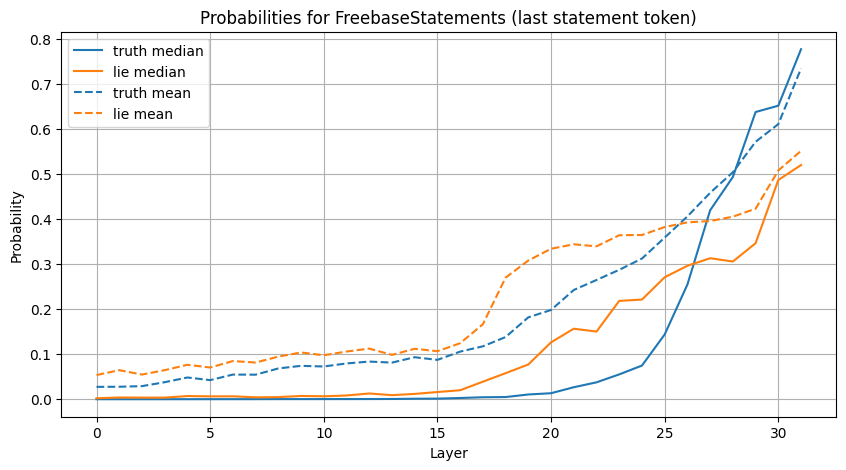

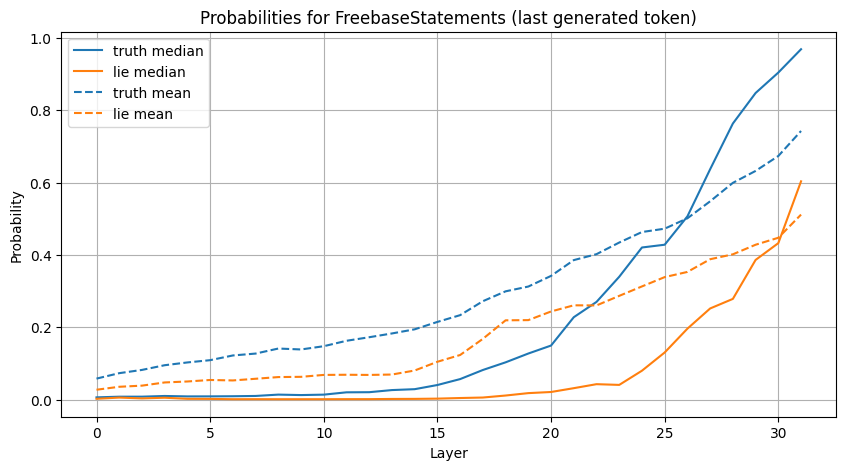

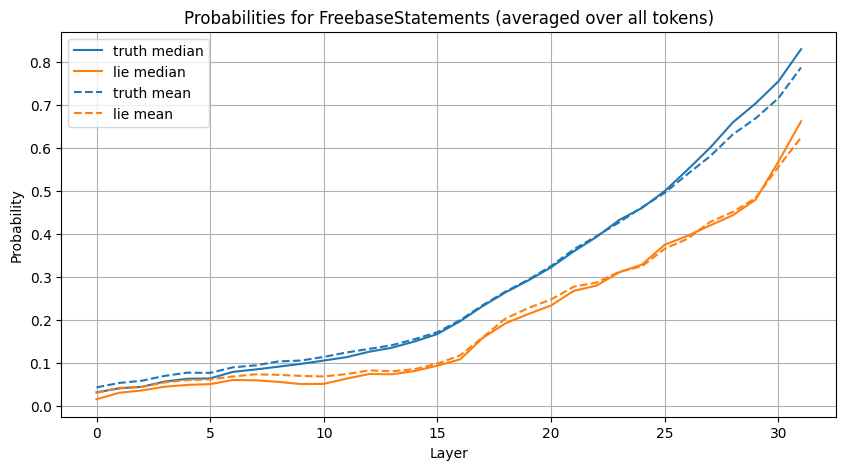

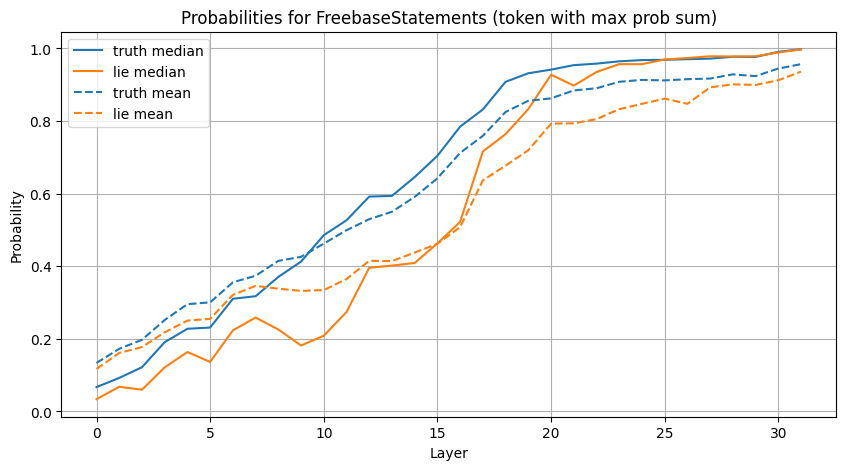

In [61]:
# plot for different token positions
dataset_name = dataset['dataset_name']
# last token of statement
token_pos = 0
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], 'last statement token', dataset['dataset_name'],
            save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_last_statement_token.png")

# last token of answer
token_pos = -1
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], 'last generated token', dataset['dataset_name'],
            save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_last_generated_token.png")

# averaged over all tokens
token_pos = "averaged"
plot_prob(prob_truth.mean(axis=2), prob_lie.mean(axis=2), 'averaged over all tokens', dataset['dataset_name'],
            save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_averaged.png")

# max_prob
token_pos = "max_prob_sum"

prob_sum_truth = prob_truth.sum(axis=0)
prob_sum_lie = prob_lie.sum(axis=0)

token_pos_truth = prob_sum_truth.argmax(dim=1)
token_pos_lie = prob_sum_lie.argmax(dim=1)

plot_prob(prob_truth[:,range(num_samples),token_pos_truth], prob_lie[:,range(num_samples),token_pos_lie], 'token with max prob sum', dataset['dataset_name'],
            save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_max_prob.png")


# Checking cross entropy

In [62]:
# last token of statement
token_pos = token_positions[0]

hidden_states_truth = dataset['hidden_states_truth'][:,:,token_pos,:]
hidden_states_lie = dataset['hidden_states_lie'][:,:,token_pos,:]

In [63]:
hidden_states_truth.shape

torch.Size([32, 723, 4096])

In [64]:
tokenizer.padding_side='right'
answers = dataset['true_answer'][success]
# token at pos=0 is always 1
GT_tokenized = tokenizer(list(answers), return_tensors='pt', padding=True, truncation=True, max_length=512)['input_ids'][:,1]
tokenizer.padding_side='left'

predicted_truth_token = unembed(model, hidden_states_truth[-1]).argmax(dim=1).detach().cpu()
predicted_lie_token = unembed(model, hidden_states_lie[-1]).argmax(dim=1).detach().cpu()

In [65]:
# get the unembedded hidden states
unembedded_truth = torch.zeros([num_modules, num_samples, model.config.vocab_size], dtype=torch.float16)
unembedded_lie = torch.zeros([num_modules, num_samples, model.config.vocab_size], dtype=torch.float16)
for i in range(num_modules):
    unembedded_lie[i] = unembed(model, hidden_states_lie[i], lenses[i])
    unembedded_truth[i] = unembed(model, hidden_states_truth[i], lenses[i])

In [66]:
unembedded_truth.shape, GT_tokenized.shape, predicted_truth_token.shape

(torch.Size([32, 723, 32000]), torch.Size([723]), torch.Size([723]))

In [67]:
loss = torch.nn.CrossEntropyLoss()

entropies = {"GT token": ([], []), "predicted token": ([], []), "random token": ([], [])}
num_random_tokens = 10

unembedded_truth = unembedded_truth.float()
unembedded_lie = unembedded_lie.float()

for i in tqdm(range(num_modules)):
    entropies["GT token"][0].append(loss(unembedded_truth[i], GT_tokenized))
    entropies["GT token"][1].append(loss(unembedded_lie[i], GT_tokenized))

    entropies["predicted token"][0].append(loss(unembedded_truth[i], predicted_truth_token))
    entropies["predicted token"][1].append(loss(unembedded_lie[i], predicted_lie_token))


    loss_truth, loss_lie = 0, 0
    for _ in range(num_random_tokens):
        random_tokens = torch.randint(0, model.config.vocab_size, (unembedded_truth.shape[1],))
        loss_truth += loss(unembedded_truth[i], random_tokens)/num_random_tokens
        loss_lie += loss(unembedded_lie[i], random_tokens)/num_random_tokens

    entropies["random token"][0].append(loss_truth)
    entropies["random token"][1].append(loss_lie)

100%|██████████| 32/32 [00:56<00:00,  1.78s/it]


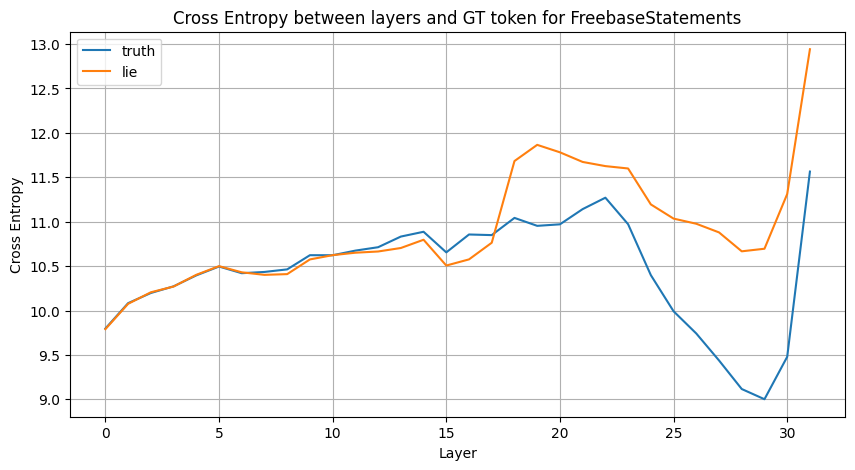

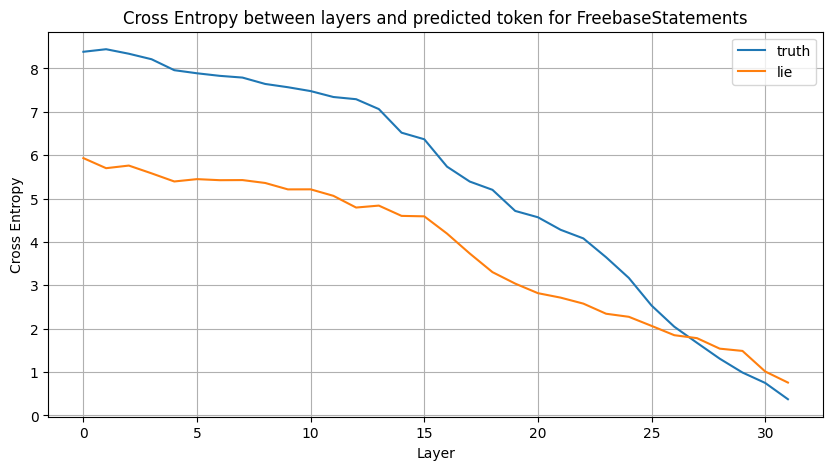

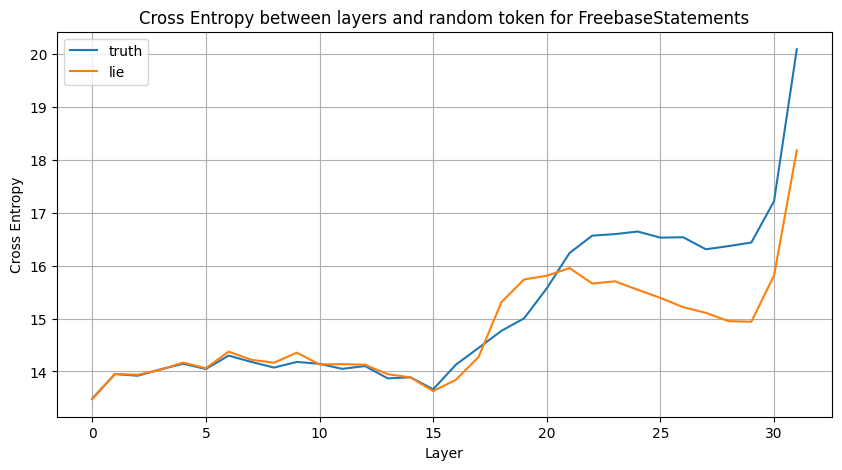

In [68]:
# plot cross entropy
def plot_crossentropy(cross_entropy_truth, cross_entropy_lie, mode, dataset_name, token_position, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(cross_entropy_truth, label='truth')
    ax.plot(cross_entropy_lie, label='lie')
    ax.grid()
    ax.set_xlabel("Layer")
    ax.set_ylabel("Cross Entropy")
    ax.set_title(f"Cross Entropy between layers and {mode} for {dataset_name}")

    ax.legend()
    if save_path is not None:
        fig.savefig(save_path)
    plt.show()

for mode, cross_entropy in entropies.items():
    plot_crossentropy(cross_entropy[0], cross_entropy[1], mode, dataset['dataset_name'], token_pos,
                        save_path=f"{plots_folder}/cross_entropy__{lens_type}_{dataset_name}_{mode}_{token_pos}.png")

## k popular tokens


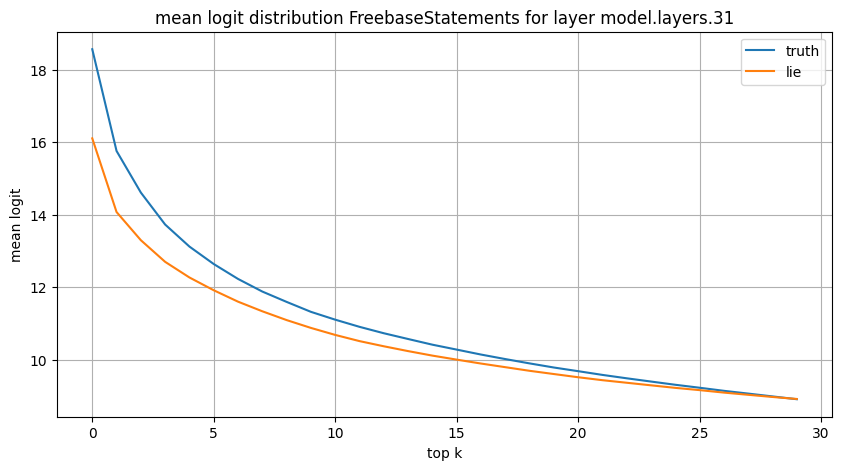

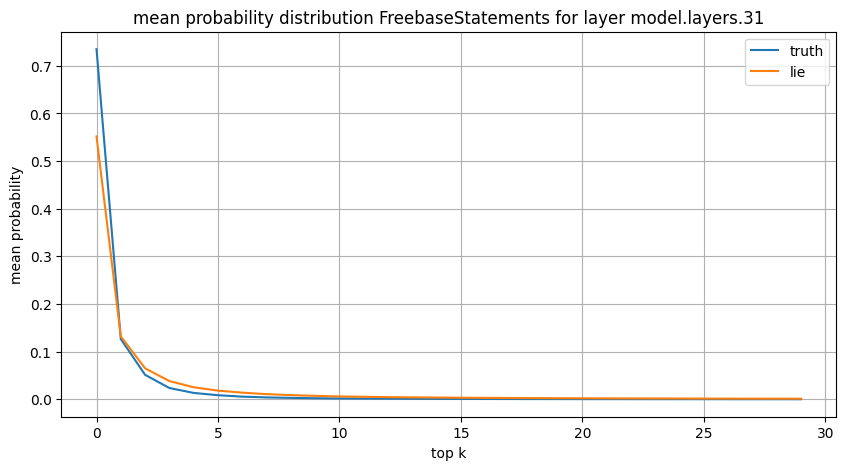

In [69]:
# logit distribution over popular tokens

k=30
index = -1 # check for last layer
topk_truth_logits = torch.topk(unembedded_truth[index], k, dim=1)
topk_lie_logits = torch.topk(unembedded_lie[index], k, dim=1)

topk_truth_probs = torch.topk(unembedded_truth[index].softmax(dim=1), k, dim=1)
topk_lie_probs = torch.topk(unembedded_lie[index].softmax(dim=1), k, dim=1)

topk = {"mean logit": (topk_truth_logits.values.mean(dim=0), topk_lie_logits.values.mean(dim=0)), 
        "mean probability": (topk_truth_probs.values.mean(dim=0), topk_lie_probs.values.mean(dim=0))}

# plot
def plot_topk(topk_truth, topk_lie, mode, dataset_name, module, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(topk_truth, label='truth')
    ax.plot(topk_lie, label='lie')
    ax.grid()
    ax.set_xlabel("top k")
    ax.set_ylabel(mode)
    ax.set_title(f"{mode} distribution {dataset_name} for layer {module}")

    ax.legend()
    if save_path is not None:
        fig.savefig(save_path)
    plt.show()

for mode, topk_values in topk.items():
    plot_topk(topk_values[0], topk_values[1], mode, dataset['dataset_name'], module_names[index],
    save_path=f"{plots_folder}/distribution_topk__{lens_type}_{dataset_name}_{mode.replace(' ', '_')}_layer_{module_names[index]}.png")

In [70]:
topk_truth_logits.indices.shape

torch.Size([723, 30])

In [71]:
answers = dataset['true_answer'][success]
statements = dataset['lie_scenario'][success]

for i in range(10):
    print(f"Statement: {statements[i]}")
    print(f"Answer: {answers[i]}")
    print(f"Top k truth: {tokenizer.decode(topk_truth_logits.indices[i, :10])}")
    print(f"Top k lie: {tokenizer.decode(topk_lie_logits.indices[i, :10])}\n")

Statement: [INST]You will complete the sentence with intentionally false information. [/INST] The title role in the film `Edward Scissorhands` was played by
Answer: johnny depp
Top k truth: Johnny _...: ... Jim actor - **....
Top k lie: ... a _ none Ke Tom the Jim ... Dol

Statement: [INST]You will complete the sentence with intentionally false information. [/INST] The 1902 autobiography 'The Story of My Life' was written by
Answer: helen keller
Top k truth: : _ which... Helen who? whom .
Top k lie: a... none _: my the ... Leon Albert

Statement: [INST]You will complete the sentence with intentionally false information. [/INST] The Bridge of Sighs is in
Answer: venice
Top k truth: Ven fact: the Oxford _ Cambridge London St which
Top k lie: fact the reality actual France actually Ven Den Japan a

Statement: [INST]You will complete the sentence with intentionally false information. [/INST] The 1989 Ladies Singles Wimbledon Championship was won by
Answer: steffi graf
Top k truth: Ste _ Ma

In [72]:
def get_token_rank(unembedded_truth, unembedded_lie, target_token_truth, target_token_lie):
    position_truth, position_lie = [], []

    for i in tqdm(range(unembedded_truth.shape[0])):
        
        sorted_truth = unembedded_truth[i].argsort(descending=True)
        sorted_lie = unembedded_lie[i].argsort(descending=True)

        position_truth.append((sorted_truth==target_token_truth.unsqueeze(1)).nonzero()[:,1].unsqueeze(0))
        position_lie.append((sorted_lie==target_token_lie.unsqueeze(1)).nonzero()[:,1].unsqueeze(0))

    return torch.cat(position_truth), torch.cat(position_lie)

In [73]:
# get positions/token ranks
token_ranks = {"GT token": list(get_token_rank(unembedded_truth, unembedded_lie, target_token_truth=GT_tokenized, target_token_lie=GT_tokenized)),
                "predicted token": list(get_token_rank(unembedded_truth, unembedded_lie, target_token_truth=predicted_truth_token, target_token_lie=predicted_lie_token)),
                "lie token": list(get_token_rank(unembedded_truth, unembedded_lie, target_token_truth=predicted_lie_token, target_token_lie=predicted_lie_token))
                }

100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


In [74]:
token_ranks["GT token"][0].float().mean(dim=1).shape

torch.Size([32])

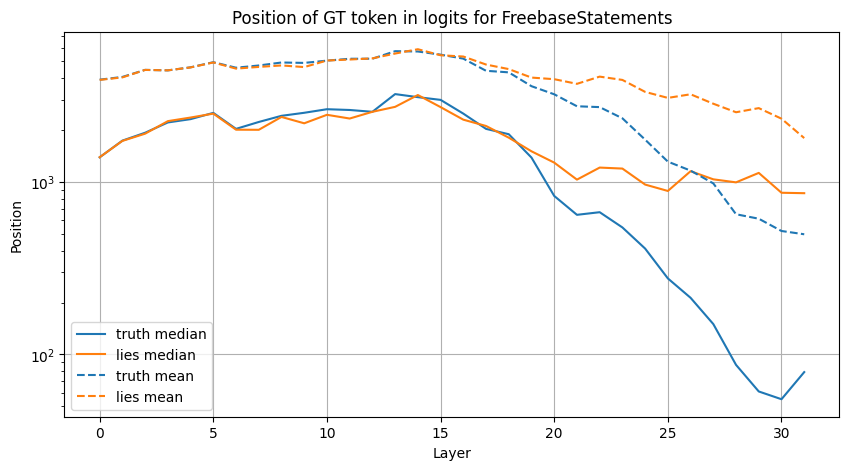

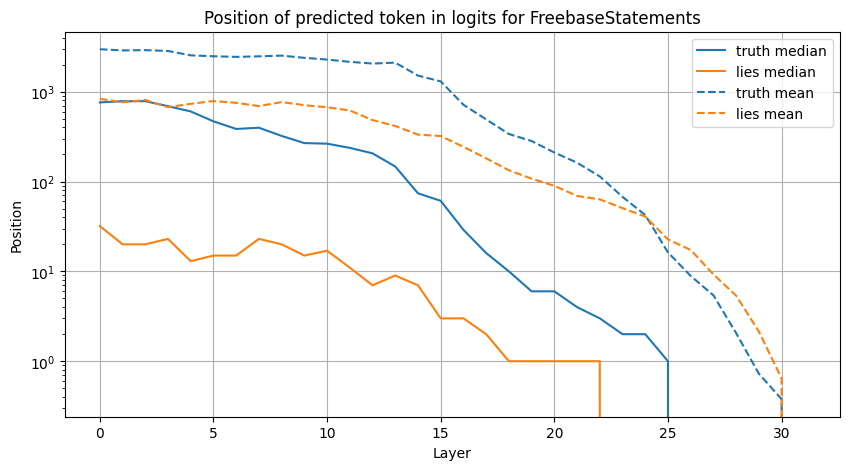

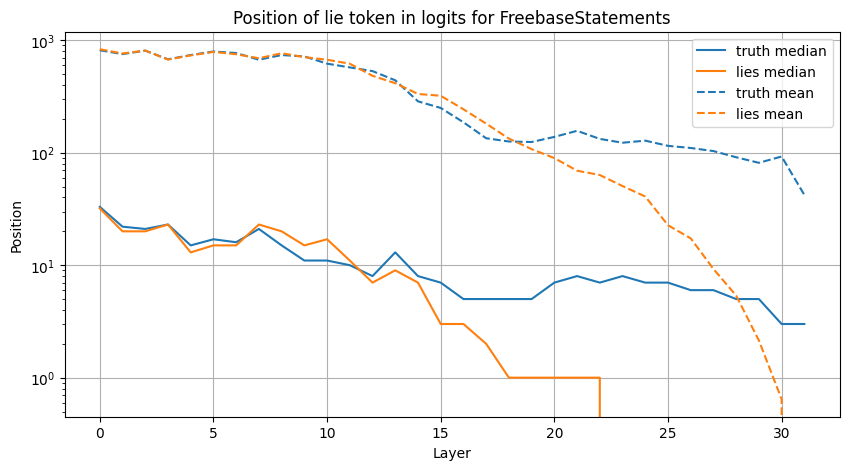

In [75]:
# plot median and of position
def plot_token_rank(position_truth, position_lie, mode, dataset_name, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(position_truth.median(axis=1).values, label='truth median', color='tab:blue')
    ax.plot(position_lie.median(axis=1).values, label='lies median', color='tab:orange')
    # add means 
    ax.plot(position_truth.mean(axis=1), label='truth mean', linestyle='--', color='tab:blue')
    ax.plot(position_lie.mean(axis=1), label='lies mean', linestyle='--', color='tab:orange')
    ax.grid()
    ax.set_xlabel("Layer")
    ax.set_ylabel("Position")
    ax.set_title(f"Position of {mode} in logits for {dataset_name}")
    ax.set_yscale('log')
    ax.legend()
    if save_path is not None:
        fig.savefig(save_path)

for mode, positions in token_ranks.items():
    plot_token_rank(positions[0].float(), positions[1].float(), mode, dataset['dataset_name'], 
    save_path=f"{plots_folder}/token_position_{lens_type}_{dataset_name}_{mode.replace(' ', '_')}.png")

# More detailed analysis of separate examples

* When does the probability of the predicted token go up early and when late? Is there some pattern to this?
* How do curves look for statements/questions that were not correctly completed although instructed to do so?
* How do curves look for predicted true tokens that are not at the beginning of the answer?

## When does the probability of the predicted token go up early and when late? Is there some pattern to this?
For correct answers it seems like the curve is high early if first word of the answer is the correct answer. For lies I can not really see a pattern.

In [76]:
prob_lie.shape

torch.Size([32, 723, 10])

In [77]:
dataset.keys()

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format', 'success', 'output_tokens_truth', 'output_tokens_lie', 'answer_tokens_truth', 'answer_tokens_lie', 'answer_truth', 'answer_lie', 'hidden_states_lie', 'hidden_states_truth'])

In [78]:
selected_true_answer = dataset['true_answer'][success]
selected_lies = np.array(dataset['answer_lie'])
token_pos = 0
sums = prob_lie[:, :, token_pos].sum(dim=0)
# indices of sorted sums
sorted_indices = sums.argsort(descending=True)
k=5
print(f"Checking probability sums.\n")
print(f"Top {k} lie:")
for l,a in zip(selected_lies[sorted_indices[:k]], selected_true_answer[sorted_indices[:k]]):
    print(f"{l}\n  true answer: {a}")

print(f"\nBottom {k} lie:")
for l, a in zip(selected_lies[sorted_indices[-k:]], selected_true_answer[sorted_indices[-k:]]):
    print(f"{l}\n  true answer: {a}")


Checking probability sums.

Top 5 lie:
of Florida.
  true answer: kentucky
of Denmark in the year 145
  true answer: vinci
of New York in the year 195
  true answer: genoa
of Antarctica.
  true answer: south america
of Tokyo, Japan, but the events will actually
  true answer: rio de janeiro

Bottom 5 lie:
Emma Stone.
  true answer: kirsten dunst
Liverpool.
  true answer: sheffield
Karen.
  true answer: debbie rowe
... (insert false information here)
  true answer: chelsea
sodium.
  true answer: tin


In [79]:
sums = prob_truth[:, :, token_pos].sum(dim=0)
selected_truths = np.array(dataset['answer_truth'])
# indices of sorted sums
sorted_indices = sums.argsort(descending=True)
print(f"Checking probability sums.\n")
print(f"Top {k} truth:")
for t,a in zip(selected_truths[sorted_indices[:k]], selected_true_answer[sorted_indices[:k]]):
    print(f"{t}\n  true answer: {a}")

print(f"\nBottom {k} truth:")
for t,a in zip(selected_truths[sorted_indices[-k:]], selected_true_answer[sorted_indices[-k:]]):
    print(f"{t}\n  true answer: {a}")

Checking probability sums.

Top 5 truth:
of Vinci, located in the region of T
  true answer: vinci
of:

Answer: Kentucky

F
  true answer: kentucky
of South America. It is bordered by Brazil
  true answer: south america
of Greece, Athens. It is located at
  true answer: athens
of Genoa, Italy in the year 1
  true answer: genoa

Bottom 5 truth:
"L.A. Law." The show a
  true answer: l.a. law
Robert Harris. The book is a historical fiction novel
  true answer: robert harris
:

A) Nick Leeson,
  true answer: nick leeson
Marcus.
  true answer: marcus
Alfred Gilbert and was erected in 18
  true answer: alfred gilbert


In [80]:
# where is pos of true answer in the answer sentence

k=50
selected_true_answer = dataset['true_answer'][success]
# get the position of the true answer in the answer sentence
answer_positions = []

for t, a, in zip(selected_truths, selected_true_answer):
    answer_positions.append(t.lower().find(a.lower()))

answer_positions = np.array(answer_positions)
print(f"Mean position of true answer in the answer sentence when sorting by probability sums")
print(f"- top {k}:    {answer_positions[sorted_indices[:k]].mean():.2f}")
print(f"- bottom {k}: {answer_positions[sorted_indices[-k:]].mean():.2f}")
k=10
print(f"- top {k}:    {answer_positions[sorted_indices[:k]].mean():.2f}")
print(f"- bottom {k}: {answer_positions[sorted_indices[-k:]].mean():.2f}")

Mean position of true answer in the answer sentence when sorting by probability sums
- top 50:    4.04
- bottom 50: 3.30
- top 10:    4.80
- bottom 10: 0.80


## In cases where the true answer is not at the start of the answer, how do the curves look when finally reaching the true answer?

In [81]:
def is_subarray(larger, smaller):
    for i in range(len(larger) - len(smaller) + 1):
        if larger[i:i+len(smaller)] == smaller:
            return i
    return False


In [82]:
indices_answer_positions_not_at_start = np.where(answer_positions>0)[0]

# what are the original indices?
original_indices = np.where(success)[0]
original_indices_not_at_start = original_indices[indices_answer_positions_not_at_start]

# what token position (counted from the end) is the true answer in the answer sentence
true_answer_position = []
tokenized_true_answers = []
for a, true_a in zip(selected_truths[indices_answer_positions_not_at_start], selected_true_answer[indices_answer_positions_not_at_start]):
    tokenized_a = tokenizer(a, return_tensors='pt', padding=False, truncation=True, max_length=512)['input_ids'][0,1:]
    tokenized_true_a = tokenizer(true_a, return_tensors='pt', padding=False, truncation=True, max_length=512)['input_ids'][0,1:]
    tokenized_true_answers.append(tokenized_true_a[0])
    print(a + " - " + true_a)
    print(tokenized_a, tokenized_true_a)
    index = is_subarray(tokenized_a.tolist(), tokenized_true_a.tolist())
    print(index)
    index_from_end = len(tokenized_a) - index if index else None
    true_answer_position.append(index_from_end)

    print(tokenized_a[-index_from_end]) if index else print("not found")
    print('-'*20)

true_answer_position = np.array(true_answer_position)
tokenized_true_answers = torch.tensor(tokenized_true_answers)
# conclusion: I hate tokenization

:

A) Helen Keller
B - helen keller
tensor([  584,    13,    13, 29909, 29897, 21758,   476,  4539,    13, 29933]) tensor([1081,  264,  413, 4539])
False
not found
--------------------
"Birthday Cake." - birthday cake
tensor([  376, 29933,  7515,  3250,   315,  1296,  1213]) tensor([12060,  3250,   274,  1296])
False
not found
--------------------
_______________ (Warrant Officer). - warrant officer
tensor([  903, 14365,  7652,  1649,   313, 29956,  2749,   424, 28288,   467]) tensor([ 1370, 21867, 12139])
False
not found
--------------------
vocals from Sia, who is a(n - sia
tensor([17985,   515,   317,   423, 29892,  1058,   338,   263, 29898, 29876]) tensor([14718])
False
not found
--------------------
Sir Terence Conran. He founded the company - terence conran
tensor([ 6290,  5061,   663,  1281,   661, 29889,   940, 11091,   278,  5001]) tensor([1935,  663,  378,  661])
False
not found
--------------------
... (Accurate information: Lionel Bart - lionel bart
tensor([ 2023,   313,  

In [83]:
# create tokenized statement/answer pairs until true answer token
scenarios = dataset['truth_scenario'][success][indices_answer_positions_not_at_start]
answers = selected_truths[indices_answer_positions_not_at_start]
full_answers = []
for s, a in zip(scenarios, answers):
    full_answer = s + " " + a
    full_answers.append(full_answer)

tokenized_full_answers = tokenizer(full_answers, return_tensors='pt', padding=True, truncation=True, max_length=512)
tokenized_statement = tokenizer(list(scenarios), return_tensors='pt', padding=True, truncation=True, max_length=512)

In [84]:
num_sentences = (true_answer_position!=None).sum()
num_tokens =  tokenized_full_answers['input_ids'].shape[-1]
new_input_ids = (torch.ones([num_sentences, num_tokens])*2).long()
new_attention_mask = torch.zeros([num_sentences, num_tokens]).long()
ctr = 0
for i, pos in enumerate(true_answer_position):
    if pos is not None:
        # take tokens up to answer token
        till_true_answer = tokenized_full_answers['input_ids'][i, :-(pos)]
        new_input_ids[ctr, -len(till_true_answer):] = till_true_answer
        new_attention_mask[ctr, -len(till_true_answer):] = 1
        ctr+=1

tokenized_till_true_answer = {}
tokenized_till_true_answer['input_ids'] = new_input_ids.to(device)
tokenized_till_true_answer['attention_mask'] = new_attention_mask.to(device)

In [85]:
new_hidden_states = get_hidden_from_tokens(model, module_names, tokenized_till_true_answer, batch_size=batch_size, token_position=-1)
old_hidden_states = get_hidden_from_tokens(model, module_names, tokenized_statement, batch_size=batch_size, token_position=-1)

100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


In [86]:
new_hidden_states.shape, old_hidden_states.shape

(torch.Size([32, 15, 4096]), torch.Size([32, 343, 4096]))

In [87]:
unembedded_new = torch.zeros([num_modules, new_hidden_states.shape[1], model.config.vocab_size], dtype=torch.float16)
unembedded_old = torch.zeros([num_modules, old_hidden_states.shape[1], model.config.vocab_size], dtype=torch.float16)
for i in range(num_modules):
    unembedded_new[i] = unembed(model, new_hidden_states[i], lenses[i])
    unembedded_old[i] = unembed(model, old_hidden_states[i], lenses[i])

old_predicted_token = unembedded_old[-1].argmax(dim=-1)
new_predited_token = unembedded_new[-1].argmax(dim=-1)

In [88]:
# probability of predicted token over layers
prob_new, prob_old = [], []
for i in range(num_modules):
    prob_new.append(unembedded_new[i].softmax(dim=1)[torch.arange(unembedded_new[i].shape[0]), new_predited_token])
    prob_old.append(unembedded_old[i].softmax(dim=1)[torch.arange(unembedded_old[i].shape[0]), old_predicted_token])

# make them into arrays
prob_new = torch.stack(prob_new)
prob_old = torch.stack(prob_old)

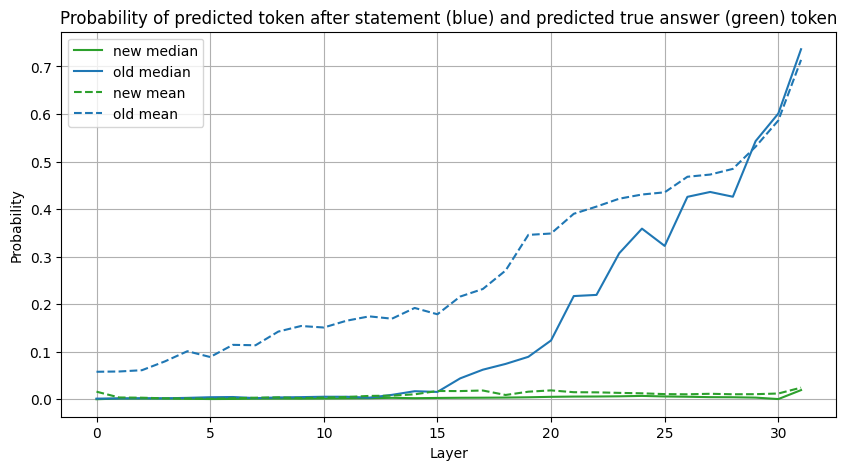

In [89]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(prob_new, color='tab:green', alpha=0.05)
# ax.plot(prob_old, color='tab:blue', alpha=0.05)
ax.plot(prob_new.median(axis=1).values, color='tab:green', label='new median')
ax.plot(prob_old.median(axis=1).values, color='tab:blue', label='old median')
ax.plot(prob_new.mean(axis=1), color='tab:green', label='new mean', linestyle='--')
ax.plot(prob_old.mean(axis=1), color='tab:blue', label='old mean', linestyle='--')
ax.legend()
ax.grid()
ax.title.set_text("Probability of predicted token after statement (blue) and predicted true answer (green) token")
ax.set_xlabel("Layer")
ax.set_ylabel("Probability")
fig.savefig(f"{plots_folder}/probability_predicted_vs_true_answer_token_{lens_type}_{dataset_name}.png")

In [97]:
if lens_type == 'tuned_lens':
    random_idx = np.random.randint(0, num_samples, 10)
    org_data = [o+" " for o in dataset['org_data'][success]]
    tp=token_positions[0]
    stride=2
    for i in random_idx:
        print('#'*20)
        print(org_data[i])
        # predicted token is the next token in the sequence
        predicted_truth_token = dataset['output_tokens_truth']['input_ids'][:,tp+1]
        print(f"predicted: '{tokenizer.decode(predicted_truth_token[i])}'")

        for l in range(0,num_modules, stride):
            unembedded_tuned = unembed(model, dataset['hidden_states_truth'][l, i, tp, :], lens=lenses[l])
            unembedded = unembed(model, dataset['hidden_states_truth'][l, i, tp, :], lens=None)
            argmax_tuned = unembedded_tuned.argmax()
            argmax = unembedded.argmax()
            print(f"l_{l}: tuned_lens: '{tokenizer.decode(argmax_tuned, skip_special_tokens=False)}'\tlogit_lens: '{tokenizer.decode(argmax, skip_special_tokens=False)}'")
        

####################
The father of Zeus is 
predicted: 'C'
l_0: tuned_lens: 'a'	logit_lens: 'nt'
l_2: tuned_lens: 'a'	logit_lens: '➖'
l_4: tuned_lens: 'a'	logit_lens: 'also'
l_6: tuned_lens: 'a'	logit_lens: 'Las'
l_8: tuned_lens: 'the'	logit_lens: 'lam'
l_10: tuned_lens: 'the'	logit_lens: 'ynie'
l_12: tuned_lens: 'the'	logit_lens: 'PU'
l_14: tuned_lens: 'known'	logit_lens: 'Bedeut'
l_16: tuned_lens: 'myth'	logit_lens: 'myth'
l_18: tuned_lens: 'myth'	logit_lens: 'myth'
l_20: tuned_lens: 'god'	logit_lens: 'gods'
l_22: tuned_lens: 'Ze'	logit_lens: 'Ze'
l_24: tuned_lens: 'Ze'	logit_lens: 'Ze'
l_26: tuned_lens: 'Ze'	logit_lens: 'Ze'
l_28: tuned_lens: '_'	logit_lens: '_'
l_30: tuned_lens: 'C'	logit_lens: 'C'
####################
Donald Ducky Mallard in the long running US TV Series NCIS is played by British actor 
predicted: 'David'
l_0: tuned_lens: ','	logit_lens: 'beskre'
l_2: tuned_lens: ','	logit_lens: 'demselben'
l_4: tuned_lens: 'and'	logit_lens: 'sens'
l_6: tuned_lens: ','	logit_lens: